In [1]:
import sys
!{sys.executable} -m pip install deap


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from deap import base, creator, tools, algorithms
import random

# Load dataset (using the JM1 dataset as an example)
data = pd.read_csv('./jm1.csv')

# Drop any missing values
data = data.dropna()

# Separate features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [3]:
# Define the evaluation function for the Genetic Algorithm
def evalFeatureSelection(individual):
    selected_features = [i for i, val in enumerate(individual) if val == 1]
    if len(selected_features) == 0:
        return (0,)
    
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    
    clf = GaussianNB()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    return (accuracy,)

In [4]:
# Set up the Genetic Algorithm using DEAP

# Create the types
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Register the functions
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalFeatureSelection)



In [5]:
# Run the Genetic Algorithm for feature selection:
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	min     	max     
0  	50    	0.794491	0.789828	0.798713
1  	34    	0.796164	0.791667	0.799326
2  	29    	0.797708	0.795343	0.800245
3  	26    	0.798137	0.788909	0.799939
4  	35    	0.798934	0.787377	0.800245
5  	28    	0.799449	0.788909	0.800245
6  	27    	0.799749	0.795343	0.801471
7  	35    	0.799994	0.796875	0.802083
8  	29    	0.800313	0.795343	0.802083
9  	24    	0.800931	0.795343	0.802083
10 	30    	0.801268	0.793811	0.80239 
11 	29    	0.801875	0.79902 	0.80239 
12 	32    	0.801912	0.796262	0.80239 
13 	19    	0.801961	0.795343	0.80239 
14 	18    	0.802034	0.796875	0.80239 
15 	25    	0.80212 	0.7981  	0.80239 
16 	39    	0.802132	0.799326	0.80239 
17 	35    	0.802108	0.797181	0.803002
18 	29    	0.80193 	0.793505	0.803002
19 	33    	0.801991	0.79565 	0.803002
20 	27    	0.802255	0.797181	0.803002


In [6]:
# Train and evaluate the Naive Bayes classifier using the best feature subset found:
best_individual = hof[0]
selected_features = [i for i, val in enumerate(best_individual) if val == 1]
print("Best individual: ", best_individual)
print("Number of selected features: ", len(selected_features))

Best individual:  [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Number of selected features:  7


In [7]:
# Train the classifier
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = GaussianNB()
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.8030024509803921
              precision    recall  f1-score   support

       False       0.81      0.98      0.89      2619
        True       0.51      0.07      0.13       645

    accuracy                           0.80      3264
   macro avg       0.66      0.53      0.51      3264
weighted avg       0.75      0.80      0.74      3264



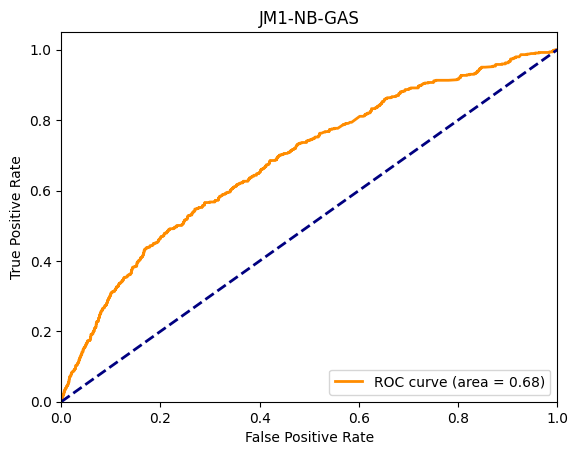

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./AUC_Extracts/JM1/JM1_NB_GAS.csv', index=False)

# Plot
plt.figure()
lw = 2  # line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('JM1-NB-GAS')
plt.legend(loc="lower right")
plt.show()